In [2]:
import numpy as np
import xarray as xr
import matplotlib as mpl 
from scipy.stats import linregress 
from typing import Pattern, List
import os 

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import xesmf as xe 
from seam import precip, nino34

from src import  utils
from concurrent.futures import ProcessPoolExecutor

%load_ext autoreload
%autoreload 2

In [3]:
# DEFINE DIRECTORIES HERE
ERSST_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/ERSST/"
HADIS_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/HadISST/"
COBES_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/COBE_SST2/"

GPCC_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/GPCC/full_v2020/"
CRUT_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/CRU_TS4.06/"
APHR_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/APHRODITE/"

In [4]:
# List of CESM2 Ensemble Members
members = ['LE2-1001.001', 'LE2-1011.001', 'LE2-1021.002', 'LE2-1031.002', 'LE2-1041.003', 'LE2-1051.003',
            'LE2-1061.004', 'LE2-1071.004', 'LE2-1081.005', 'LE2-1091.005', 'LE2-1101.006', 'LE2-1111.006',
            'LE2-1121.007', 'LE2-1131.007', 'LE2-1141.008', 'LE2-1151.008', 'LE2-1161.009', 'LE2-1171.009',
            'LE2-1181.010', 'LE2-1191.010', 
            'LE2-1231.001', 'LE2-1231.002', 'LE2-1231.003', 'LE2-1231.004',
            'LE2-1231.005', 'LE2-1231.006', 'LE2-1231.007', 'LE2-1231.008', 'LE2-1231.009', 'LE2-1231.010',
            'LE2-1231.011', 'LE2-1231.012', 'LE2-1231.013', 'LE2-1231.014', 'LE2-1231.015', 'LE2-1231.016',
            'LE2-1231.017', 'LE2-1231.018', 'LE2-1231.019', 'LE2-1231.020',
            'LE2-1251.001', 'LE2-1251.002', 'LE2-1251.003', 'LE2-1251.004',
            'LE2-1251.005', 'LE2-1251.006', 'LE2-1251.007', 'LE2-1251.008', 'LE2-1251.009', 'LE2-1251.010',
            'LE2-1251.011', 'LE2-1251.012', 'LE2-1251.013', 'LE2-1251.014', 'LE2-1251.015', 'LE2-1251.016',
            'LE2-1251.017', 'LE2-1251.018', 'LE2-1251.019', 'LE2-1251.020',
            'LE2-1301.001', 'LE2-1301.002', 'LE2-1301.003', 'LE2-1301.004', 'LE2-1301.005', 'LE2-1301.006',
            'LE2-1301.007', 'LE2-1301.008', 'LE2-1301.009', 'LE2-1301.010', 'LE2-1301.011', 'LE2-1301.012', 
            'LE2-1301.013', 'LE2-1301.014', 'LE2-1301.015', 'LE2-1301.016', 'LE2-1301.017', 'LE2-1301.018',
            'LE2-1301.019', 'LE2-1301.020',
            'LE2-1281.001', 'LE2-1281.002', 'LE2-1281.003', 'LE2-1281.004', 'LE2-1281.005', 'LE2-1281.006',
            'LE2-1281.007', 'LE2-1281.008', 'LE2-1281.009', 'LE2-1281.010', 'LE2-1281.011', 'LE2-1281.012',
            'LE2-1281.013', 'LE2-1281.014', 'LE2-1281.015', 'LE2-1281.016', 'LE2-1281.017', 'LE2-1281.018',
            'LE2-1281.019', 'LE2-1281.020']
print(len(members))

100


In [5]:
# Open all precip. datasets
precip_anm_G = utils.get_obs_precip_anomalies(
    source="GPCC", 
    months=[3, 4, 5], detrend=True
    )

precip_anm_C = utils.get_obs_precip_anomalies(
    source="CRUT", 
    months=[3, 4, 5], detrend=True
    )

precip_anm_A = utils.get_obs_precip_anomalies(
    source="APHR", 
    months=[3, 4, 5], detrend=True
    )

In [6]:
# Open all Nino3.4 SST datasets
sst_anm_nino34_E = utils.get_obs_nino34_sst_anomalies(
    source="ERSST",
    detrend=True
)

sst_anm_nino34_H = utils.get_obs_nino34_sst_anomalies(
    source="HADISST", 
    detrend=True
)

sst_anm_nino34_C = utils.get_obs_nino34_sst_anomalies(
    source="COBESST", 
    detrend=True
)

In [7]:
def plot_line(x, y, ax, color, linewidth=1):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Generate x values for the trend line
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = intercept + slope * x_fit

    ax.plot(x_fit, y_fit, color=color, linestyle='-', linewidth=linewidth)
    
    return slope


In [8]:
precip_anms = [
    precip_anm_G # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_E #E,H,C
]

In [9]:
# Open CESM2-LE data for running correlation
N=13 # running mean correlation
def process_member(ens):
    print(f"Processing {ens}")
    monthly_sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.Nino34.nc")
    sst_anm = utils.get_model_sst_anomalies(monthly_sst_da, detrend=False)
    
    prec_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.PRECT.MSEA.nc")
    precip_anm = utils.get_model_precip_anomalies(prec_da, months=[3,4,5], detrend=False)

    print("Getting running correlation...")
    corr_lead = utils.get_running_corr(precip_anm, sst_anm.shift(time=1), window=N)
    
    return (corr_lead, precip_anm, sst_anm)
    
def main(members):
    lead_correlations = []
    all_precips = []
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        corr_lead, precip_anm, sst_anm = result
        lead_correlations.append(corr_lead)
        all_precips.append(precip_anm)
        all_ssts.append(sst_anm)
    return lead_correlations, all_precips, all_ssts

lead_correlations, all_precips, all_ssts = main(members)

Processing LE2-1001.001
Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004


Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006
Processing LE2-1111.006
Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008
Processing LE2-1161.009
Processing LE2-1171.009
Processing LE2-1181.010
Processing LE2-1191.010
Processing LE2-1231.002
Processing LE2-1231.003Processing LE2-1231.001

Processing LE2-1231.004
Processing LE2-1231.005Processing LE2-1231.006

Processing LE2-1231.007
Processing LE2-1231.008
Processing LE2-1231.009
Processing LE2-1231.010
Processing LE2-1231.011
Processing LE2-1231.012
Getting running correlation...Getting running correlation...

Processing LE2-1231.013

Processing LE2-1231.014Getting running correlation...Getting running correlation...

Processing LE2-1231.015

Getting running correlation...Getting running correlation...Processing LE2-1231.017Processing LE2-1231.016


Getting running correlation...Getting running correlation...

Processing LE2-1231.018Processing LE2-1231.019

Getting 

In [10]:
lead_correlations_da = xr.concat(lead_correlations, dim='ensemble')
precips_da = xr.concat(all_precips, dim='ensemble')
ssts_da = xr.concat(all_ssts, dim='ensemble')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_1877308/514506610.py:115: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("FigS6.png")
/tmp/ipykernel_1877308/514506610.py:116: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("FigS6.pdf")
/tmp/ipykernel_1877308/514506610.py:116: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("FigS6.pdf")
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


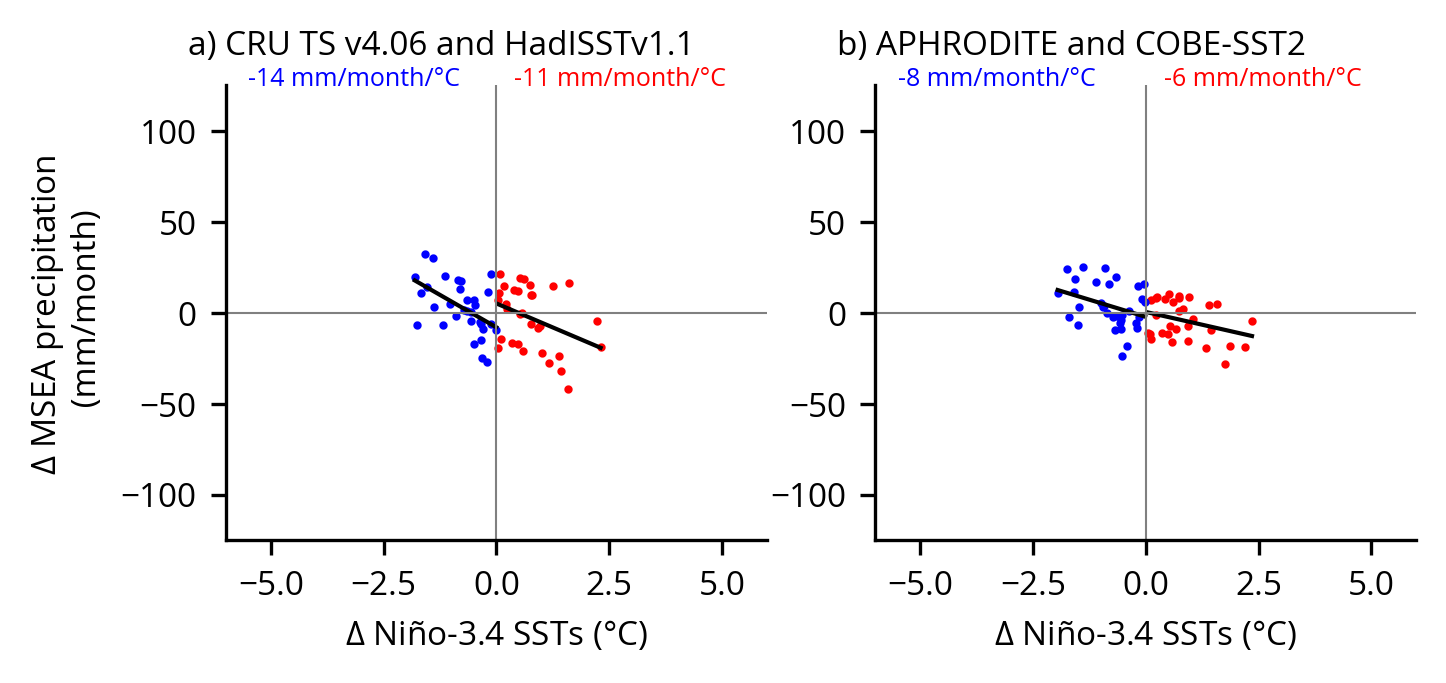

In [11]:
%matplotlib inline 

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 12
fig_height_cm = 5.5

fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(1, 2, top=0.90, bottom=0.2, left=0.15, right=0.99, hspace=0.6, wspace=0.2)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])

############## Figure 4a ##############

precip_anms = [
    precip_anm_C # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_H #E,H,C
]


for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    sst_shifted = sst_anm_nino34.shift(time=1)

    precip_anm = precip_anm.sel(time=slice('1951','2015'))
    sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

    elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values


    ax1.scatter(elnino_sst,elnino_pre,color="red", s=1)
    ax1.scatter(lanina_sst,lanina_pre,color="blue", s=1)
    
    slope = plot_line(elnino_sst, elnino_pre, ax=ax1, color='k')
    ax1.text(0.4, 125, f'{slope:.0f} mm/month/°C', color='red', fontsize=6)

    slope = plot_line(lanina_sst, lanina_pre, ax=ax1, color='k')
    ax1.text(-5.5, 125, f'{slope:.0f} mm/month/°C', color='blue', fontsize=6)

############## Figure 4b ##############


precip_anms = [
    precip_anm_A # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_C #E,H,C
]

for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    sst_shifted = sst_anm_nino34.shift(time=1)

    precip_anm = precip_anm.sel(time=slice('1951','2015'))
    sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

    elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values


    ax2.scatter(elnino_sst,elnino_pre,color="red", s=1)
    ax2.scatter(lanina_sst,lanina_pre,color="blue", s=1)
    
    slope = plot_line(elnino_sst, elnino_pre, ax=ax2, color='k')
    ax2.text(0.4, 125, f'{slope:.0f} mm/month/°C', color='red', fontsize=6)

    slope = plot_line(lanina_sst, lanina_pre, ax=ax2, color='k')
    ax2.text(-5.5, 125, f'{slope:.0f} mm/month/°C', color='blue', fontsize=6)


for ax in [ax1, ax2]:
    ax.set_xlim(-6,6)
    ax.set_ylim(-125,125)
    ax.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower left', frameon=False, fontsize=6)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)

ax1.set_ylabel("$\Delta$ MSEA precipitation \n (mm/month)")

# Set subplot labels
titles1 = ["a) CRU TS v4.06 and HadISSTv1.1", "b) APHRODITE and COBE-SST2"]
titles2 = [None, None]
colors = ['k', 'k']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.05), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

plt.savefig("FigS6.png")
plt.savefig("FigS6.pdf")


In [12]:
def get_file_list(directory_path: str, compiled_regex: Pattern):
    """Return a list of file paths in a directory matching the regex pattern.

    Args:
        directory_path (str): path to directory where to look for files
        compiled_regex (pattern): compiled regex pattern to match

    Returns:
        file_list (list[str]): list of file paths

    """

    file_list = []
    for file_name in os.listdir(directory_path):
        if compiled_regex.match(file_name):
            file_list.append(os.path.join(directory_path, file_name))

    # Important!!! Sort to concatenate chronologically
    file_list.sort()

    return file_list

In [13]:
models = ['ACCESS-CM2', 
          'ACCESS-ESM1-5', 
          'BCC-CSM2-MR', 
          'BCC-ESM1',
          'CAMS-CSM1-0',
          'CanESM5', 
          'CAS-ESM2-0',
          'CESM2-FV2',
          'CESM2-WACCM-FV2', 
          #'CESM2-WACCM',
          'CIESM', 
          'E3SM-1-0', 
          'E3SM-1-1-ECA',
          'E3SM-1-1', 
          'E3SM-2-0',
          'E3SM-2-0-NARRM',
          'EC-Earth3-AerChem',
          'EC-Earth3-CC', 
          'EC-Earth3', 
          'EC-Earth3-Veg-LR', 
          'FGOALS-g3', 
          'FGOALS-f3-L',
          'FIO-ESM-2-0', 
          'GFDL-CM4',
          'GFDL-ESM4', 
          'GISS-E2-1-G', 
          'GISS-E2-1-H',
          'GISS-E2-2-H',
          #'IITM-ESM',
          'INM-CM4-8', 
          'INM-CM5-0', 
          'IPSL-CM6A-LR', 
          'KACE-1-0-G',
           #'KIOST-ESM',
          'MCM-UA-1-0', 
          'MIROC6', 
          'MPI-ESM-1-2-HAM', 
          'MPI-ESM1-2-HR', 
          'MPI-ESM1-2-LR',
          'MRI-ESM2-0', 
          'NESM3', 
          'NorCPM1',
          'NorESM2-LM', 
          'NorESM2-MM', 
          'SAM0-UNICON']


In [14]:
tos_dir = '/net/fs03/d0/eleroy/data-dirs/SEAM/data/ExtData/CMIP6/historical/r1i1p1f1/Omon/tos'
pr_dir = '/net/fs03/d0/eleroy/data-dirs/SEAM/data/ExtData/CMIP6/historical/r1i1p1f1/Amon/pr'

tos_files = {model: [] for model in models}
pr_files = {model: [] for model in models}

for file_name in os.listdir(tos_dir):
    for model in models:
        if f"_{model}_" in file_name or file_name.endswith(f"_{model}.nc"):
            full_path = os.path.join(tos_dir, file_name)
            tos_files[model].append(full_path)

for file_name in os.listdir(pr_dir):
    for model in models:
        if f"_{model}_" in file_name or file_name.endswith(f"_{model}.nc"):
            full_path = os.path.join(pr_dir, file_name)
            pr_files[model].append(full_path)


In [15]:
ds_out = xr.open_mfdataset(tos_files['E3SM-1-0'])

def get_cmip6_da(file):
    da = xr.open_mfdataset(file, engine='netcdf4')

    if da.parent_source_id == "CIESM":
        if "pr" in da.variables:
            da = da*1e3

    if "lat" in da.coords and "lon" in da.coords:
        return da
    elif "latitude" in da.coords and "longitude" in da.coords:
        da = da.rename({"latitude": "lat", "longitude": "lon"})
    elif "nav_lat" in da.coords and "nav_lon" in da.coords:
        da = da.rename({"nav_lat": "lat", "nav_lon": "lon"})

    if (da.lon < 0).any():
        da.coords['lon'] = (da.coords['lon'] % 360)

    if "bnds" in da.coords:  # and "lon" in da.coords:
        da = da.drop_dims(["bnds"])
    if "vertices" in da.coords:
        da = da.drop_dims(["vertices"])
    if "nvertex" in da.coords:
        da = da.drop_dims(["nvertex"])
    if "axis_nbounds" in da.coords:
        da = da.drop_dims(["axis_nbounds"])

    if "i" in da.coords:  # and "lon" in da.coords:
        regridder = xe.Regridder(da, ds_out, 'nearest_s2d')
    elif "x" in da.dims:  # and "lon" in da.coords:
        print("yes")
        regridder = xe.Regridder(da, ds_out, 'nearest_s2d')
    else:
        regridder = xe.Regridder(da, ds_out, 'bilinear')
    
    da_new = regridder(da)

    return da_new

In [16]:
def get_precip_sst(da_pr, da_tos):
    precip_anm = (
        precip.get_SEAM_anm_timeseries(
            da_pr,
            detrend=False,
            base_start='1951-01',
            base_end='2015-12',
            monsoon_season=False,
            monthly=True)
        )

    precip_MAM = precip_anm.sel(time=precip_anm.time.dt.season=="MAM")
    precip_anm = precip_MAM.resample(time="1Y").mean()

    sst_anm_nino34_ersst = (
        nino34.get_nino34_anm_timeseries(
            da_tos, 
            detrend=False, 
            base_start='1951-01',
            base_end='2015-12', 
            filtered=False
        )
        )
    sst_season = (
        sst_anm_nino34_ersst.resample(time="QS-DEC", label="left")
            .mean(dim='time')
        )  # take quarterly means starting Dec 1

    nino34_DJF_ersst = (
        sst_season.sel(time=sst_season.time.dt.month.isin([12]))
        .resample(time="1Y")
        .mean()
        )

    return precip_anm.sel(time=slice('1900','2014')), nino34_DJF_ersst.sel(time=slice('1900','2014'))


In [17]:
cmip6_precip_anms = []
cmip6_tos_anms = []

sorted_models = sorted(models)

for model in sorted_models:
    print(model)
    ds_tos = get_cmip6_da(tos_files[model])
    ds_pr = get_cmip6_da(pr_files[model])

    da_tos = ds_tos['tos'].sel(time=slice('1900','2014'))
    da_pr = ds_pr['pr'].sel(time=slice('1900','2014'))

    da_pr = da_pr * 30 * 24 *60 *60 # days × 24 hours/day × 60 minutes/hour × 60 seconds/minute)

    precip_anm, nino34_DJF_ersst = get_precip_sst(da_pr, da_tos)

    cmip6_precip_anms.append(precip_anm)
    cmip6_tos_anms.append(nino34_DJF_ersst)
    print(model)



ACCESS-CM2
ACCESS-CM2
ACCESS-ESM1-5
ACCESS-ESM1-5
BCC-CSM2-MR
BCC-CSM2-MR
BCC-ESM1
BCC-ESM1
CAMS-CSM1-0
CAMS-CSM1-0
CAS-ESM2-0
CAS-ESM2-0
CESM2-FV2


/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/con

CESM2-FV2
CESM2-WACCM-FV2


/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/co

CESM2-WACCM-FV2
CIESM
CIESM
CanESM5
CanESM5
E3SM-1-0
E3SM-1-0
E3SM-1-1
E3SM-1-1
E3SM-1-1-ECA
E3SM-1-1-ECA
E3SM-2-0
E3SM-2-0
E3SM-2-0-NARRM
E3SM-2-0-NARRM
EC-Earth3
EC-Earth3
EC-Earth3-AerChem
EC-Earth3-AerChem
EC-Earth3-CC
EC-Earth3-CC
EC-Earth3-Veg-LR
EC-Earth3-Veg-LR
FGOALS-f3-L
FGOALS-f3-L
FGOALS-g3
FGOALS-g3
FIO-ESM-2-0
FIO-ESM-2-0
GFDL-CM4
GFDL-CM4
GFDL-ESM4
GFDL-ESM4
GISS-E2-1-G
GISS-E2-1-G
GISS-E2-1-H
GISS-E2-1-H
GISS-E2-2-H
GISS-E2-2-H
INM-CM4-8
INM-CM4-8
INM-CM5-0
INM-CM5-0
IPSL-CM6A-LR
yes
IPSL-CM6A-LR
KACE-1-0-G
KACE-1-0-G
MCM-UA-1-0
MCM-UA-1-0
MIROC6
yes
MIROC6
MPI-ESM-1-2-HAM
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MPI-ESM1-2-LR
MRI-ESM2-0
MRI-ESM2-0
NESM3
NESM3
NorCPM1
NorCPM1
NorESM2-LM
NorESM2-LM
NorESM2-MM
NorESM2-MM
SAM0-UNICON
SAM0-UNICON


In [18]:
colors = plt.cm.get_cmap('tab20b', 34)  # 'tab20b' or 'tab20', 'Set3', 'tab10' etc.


In [19]:
sorted_models

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'CESM2-FV2',
 'CESM2-WACCM-FV2',
 'CIESM',
 'CanESM5',
 'E3SM-1-0',
 'E3SM-1-1',
 'E3SM-1-1-ECA',
 'E3SM-2-0',
 'E3SM-2-0-NARRM',
 'EC-Earth3',
 'EC-Earth3-AerChem',
 'EC-Earth3-CC',
 'EC-Earth3-Veg-LR',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'GISS-E2-2-H',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MCM-UA-1-0',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorCPM1',
 'NorESM2-LM',
 'NorESM2-MM',
 'SAM0-UNICON']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
CESM2-FV2
CESM2-WACCM-FV2
CIESM
CanESM5
E3SM-1-0
E3SM-1-1
E3SM-1-1-ECA
E3SM-2-0
E3SM-2-0-NARRM
EC-Earth3
EC-Earth3-AerChem
EC-Earth3-CC
EC-Earth3-Veg-LR
FGOALS-f3-L
FGOALS-g3
FIO-ESM-2-0
GFDL-CM4
GFDL-ESM4
GISS-E2-1-G
GISS-E2-1-H
GISS-E2-2-H
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
MCM-UA-1-0
MIROC6
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorCPM1
NorESM2-LM
NorESM2-MM
SAM0-UNICON
[0.6263257397440208, 0.2460463622229466, 0.8940791087534042, 0.047945619068722974, 1.071599958190365, 0.4744157695373119, 0.37037294776042456, 1.5661409220378981, 0.7549251006377325, 0.41881922201037236, 0.45774632121155084, 0.71265985154881, 0.1899505077610454, 0.6509659453457037, 1.000863601280798, 0.35687963994934074, 0.6430084979151184, 0.7523673501702076, 0.37702476406009494, 0.23860084051092792, 0.09184683470794407, 0.31664502907237907, 1.867469445536428, 0.8880669551892565, 0.3521234667820403, 0.0165209317456379

/tmp/ipykernel_1877308/3332310641.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Fig4.png")
/tmp/ipykernel_1877308/3332310641.py:153: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Fig4.pdf")
/tmp/ipykernel_1877308/3332310641.py:153: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Fig4.pdf")
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


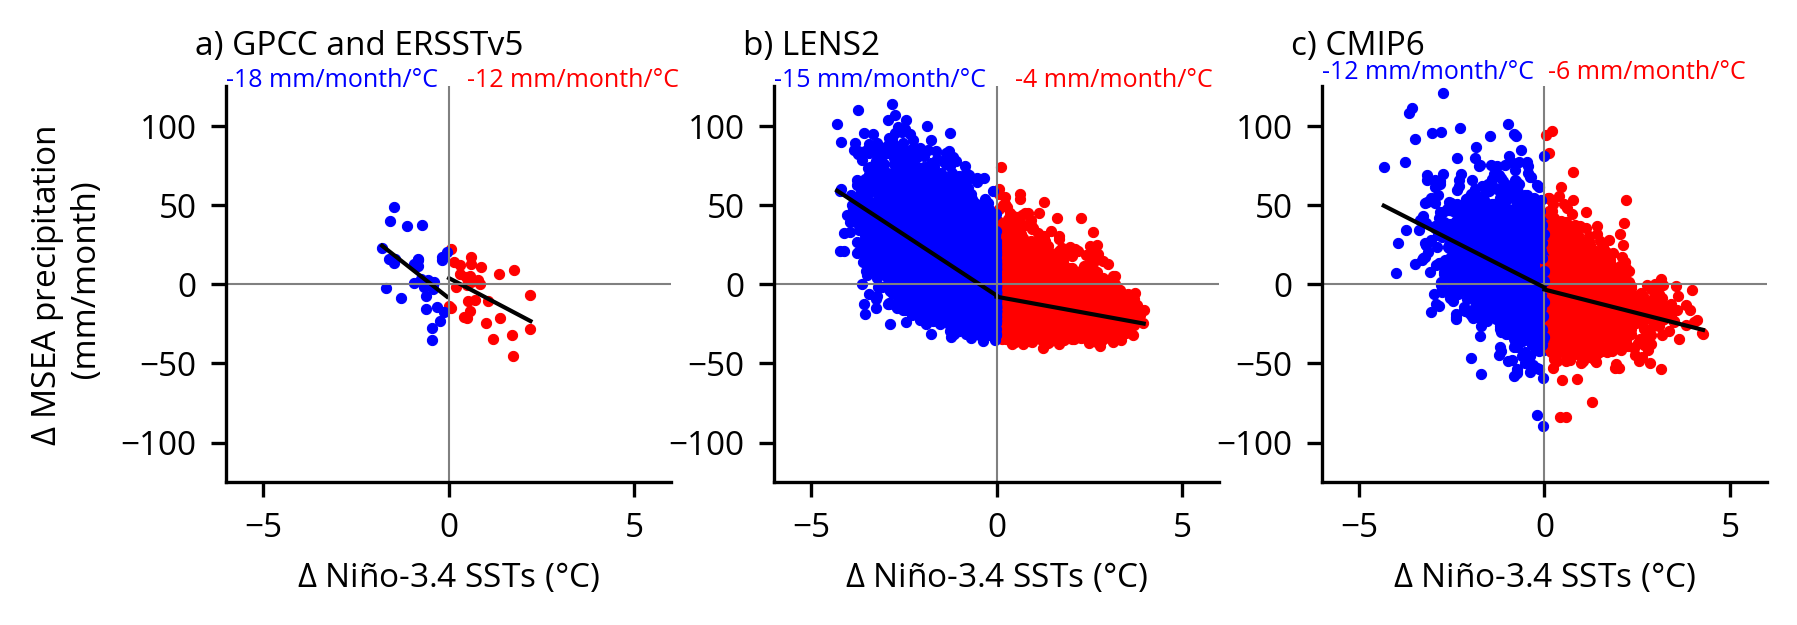

In [23]:
precip_anms = [
    precip_anm_G # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_E #E,H,C
]

%matplotlib inline 

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 15
fig_height_cm = 5
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(1, 3, top=0.89, bottom=0.22, left=0.12, right=0.99, hspace=0.2, wspace=0.23)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[0, 2])

############## Figure 4a ##############

for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    sst_shifted = sst_anm_nino34.shift(time=1)

    precip_anm = precip_anm.sel(time=slice('1951','2015'))
    sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

    elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values

    ax1.scatter(elnino_sst, elnino_pre, marker='o', edgecolors='red', facecolors='red', s=6, linewidths=0.25, alpha=1)
    ax1.scatter(lanina_sst, lanina_pre, marker='o', edgecolors='blue', facecolors='blue', s=6, linewidths=0.25, alpha=1)

    slope = plot_line(elnino_sst, elnino_pre, ax=ax1, color='k')
    ax1.text(0.5, 125, f'{slope:.0f} mm/month/°C', color='red', fontsize=6)

    slope = plot_line(lanina_sst, lanina_pre, ax=ax1, color='k')
    ax1.text(-6, 125, f'{slope:.0f} mm/month/°C', color='blue', fontsize=6)

############## Figure 4b ##############

sst_shifted = ssts_da.shift(time=1)

precip_anm = precips_da.sel(time=slice('1900','2015'))
sst_shifted = sst_shifted.sel(time=slice('1900','2015'))

elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values

ax2.scatter(elnino_sst, elnino_pre, marker='o', edgecolors='red', facecolors='red', s=6, linewidths=0.25, alpha=1)
ax2.scatter(lanina_sst, lanina_pre, marker='o', edgecolors='blue', facecolors='blue', s=6, linewidths=0.25, alpha=1)

slope = plot_line(elnino_sst[~np.isnan(elnino_sst)].flatten(), elnino_pre[~np.isnan(elnino_pre)].flatten(), ax=ax2, color='black')
ax2.text(0.5, 125, f'{slope:.0f} mm/month/°C', color='red', fontsize=6)
slope = plot_line(lanina_sst[~np.isnan(lanina_sst)].flatten(), lanina_pre[~np.isnan(lanina_pre)].flatten(), ax=ax2, color='black')
ax2.text(-6, 125, f'{slope:.0f} mm/month/°C', color='blue', fontsize=6)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower left', frameon=False, fontsize=6)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)

ax1.set_ylabel("$\Delta$ MSEA precipitation \n (mm/month)")

criteria = sorted_models #sorted_models #GPMs #non_cesm_models #GPM

slope_elninos = []
slope_laninas = []

############## Figure 4c ##############
for idx, (precip_anm, sst_anm_nino34) in enumerate(zip(cmip6_precip_anms, cmip6_tos_anms)):
    if sorted_models[idx] == "NESM3":
        precip_anm['time'] = sst_anm_nino34.time
    if sorted_models[idx] in criteria:
        print(sorted_models[idx])
        sst_shifted = sst_anm_nino34.shift(time=1)
        
        elnino_sst = sst_shifted.where(sst_shifted > 0, drop=True).values
        lanina_sst = sst_shifted.where(sst_shifted < 0, drop=True).values
        
        elnino_pre = precip_anm.where(sst_shifted > 0, drop=True).values
        lanina_pre = precip_anm.where(sst_shifted < 0, drop=True).values

        ax3.scatter(elnino_sst, elnino_pre, marker='o', edgecolors='red', facecolors='red', s=6, linewidths=0.25, alpha=1)
        ax3.scatter(lanina_sst, lanina_pre, marker='o', edgecolors='blue', facecolors='blue', s=6, linewidths=0.25, alpha=1)
        
        slope_elninos.append(slope)
        slope_laninas.append(slope)

elnino_sst_all = []
elnino_pre_all = []
lanina_sst_all = []
lanina_pre_all = []
for precip_anm, sst_anm_nino34, sorted_model in zip(cmip6_precip_anms, cmip6_tos_anms, sorted_models):
    if sorted_model in criteria:
        sst_shifted = sst_anm_nino34.shift(time=1)

        elnino_sst = sst_shifted.where(sst_shifted > 0, drop=True).values
        lanina_sst = sst_shifted.where(sst_shifted < 0, drop=True).values
        
        elnino_pre = precip_anm.where(sst_shifted > 0, drop=True).values
        lanina_pre = precip_anm.where(sst_shifted < 0, drop=True).values

        elnino_sst_all.extend(elnino_sst)
        elnino_pre_all.extend(elnino_pre)
        lanina_sst_all.extend(lanina_sst)
        lanina_pre_all.extend(lanina_pre)

print(elnino_sst_all)
slope_elnino = plot_line(elnino_sst_all, elnino_pre_all, ax=ax3, color='k', linewidth=1)
ax3.text(0.1, 130, f'{slope_elnino:.0f} mm/month/°C', color='red', fontsize=6)

slope_lanina = plot_line(lanina_sst_all, lanina_pre_all, ax=ax3, color='k', linewidth=1)
ax3.text(-6, 130, f'{slope_lanina:.0f} mm/month/°C', color='blue', fontsize=6)

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(-125, 125)
    ax.set_xlim(-6, 6)   

# Set subplot labels
titles1 = ["a) GPCC and ERSSTv5", "b) LENS2", "c) CMIP6"]
titles2 = [None, None, None]
colors = ['k', 'k', 'k']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2, ax3], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.06), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.06), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

plt.savefig("Fig4.png")
plt.savefig("Fig4.pdf")